In [121]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 1. Exponential fit

In [174]:
data = scipy.io.loadmat('data_exe3.mat')

In [175]:
t = data['t'][:,0]
y = data['y'][:,0]

In [182]:
def fun_All(a, t, y):

    # Obtain F(a)
    Fa = np.exp(np.outer(t,a))

    # Compute c
    c = np.linalg.lstsq(Fa, y, rcond=0)[0]

    # Compute residuals
    y_hat = np.dot(Fa, c)
    r = y - y_hat

    # Compute Jacobin
    Lambda_t = np.diag(t)
    Lambda_c = np.diag(c)

    H = Lambda_t @ Fa

    Lambda_H = np.diag(H.T @ r)

    part1 = - Fa @ np.linalg.inv(Fa.T @ Fa)
    part2 = Lambda_H - H.T @ (Fa @ Lambda_c)
    part3 = H @ Lambda_c

    J = part1 @ part2 - part3

    return r, J, c

In [183]:
def variable_projection_method(fun_All, a0, maxit=None, *args):
    # Determine if x0 is a scalar or an array
    a = np.array(a0, ndmin=1)
    is_scalar = a.size == 1

    # Solver settings and info
    maxit = maxit if maxit is not None else 100 * (1 if is_scalar else len(a0))
    tol = 1.0e-10

    stat = {"converged": False, "nfun": 0, "iter": 0, "X": [], "F": [], "dF": []}

    # Initial iteration
    it = 0

    ra, Ja, ca = fun_All(a, *args)
    f = 0.5 * np.linalg.norm(ra, 2)**2
    df = np.dot(Ja.T, ra).flatten()

    converged = np.linalg.norm(df, np.inf) <= tol

    # Initial lambda
    lambda_val = np.linalg.norm(Ja.T @ Ja, 2)

    # Store data for plotting
    stat['X'].append(np.concatenate([ca, a]))
    stat['F'].append(f)
    stat['dF'].append(df)

    # Main loop of variable projection method
    while not converged and it < maxit:
        it += 1

        # Calculate the search direction by solving a linear LSQ problem    
        A = np.vstack([Ja, np.sqrt(lambda_val) * np.eye(len(a))])
        b = np.hstack([-ra, np.zeros_like(a)])
        p = np.linalg.lstsq(A, b, rcond=None)[0]

        # Update the iterate, Jacobian, residual, f, df
        a_new = a + p

        # Update the Lagrange parameter lambda
        ra_new, Ja_new, ca_new = fun_All(a_new, *args)
        f_new = 0.5 * np.linalg.norm(ra_new, 2)**2

        rho = (f - f_new) / (0.5 * (p @ (lambda_val * p - Ja.T @ ra)))
        if rho > 0.75:
            lambda_val /= 3
        elif rho < 0.25:
            lambda_val *= 2

        # Accept or reject a_new
        if rho > 0:
            a = a_new
            ra = ra_new
            f = f_new
            Ja = Ja_new
            ca = ca_new
            df = np.dot(Ja.T, ra).flatten()

        converged = np.linalg.norm(df, np.inf) <= tol
        stat['nfun'] += 1

        # Store data for plotting
        x = np.concatenate([ca, a])
        stat['X'].append(x)
        stat['F'].append(f)
        stat['dF'].append(df)

    stat['iter'] = it
    # Prepare return data
    if not converged:
        stat['converged'] = converged
        return None, stat
    stat['converged'] = converged
    # Convert the solution back to a scalar if the input was a scalar
    x_result = x[0] if is_scalar else x
    return x_result, stat

In [184]:
a0 = [-1,-2]
xopt, stat = variable_projection_method(fun_All, a0, None, t, y)

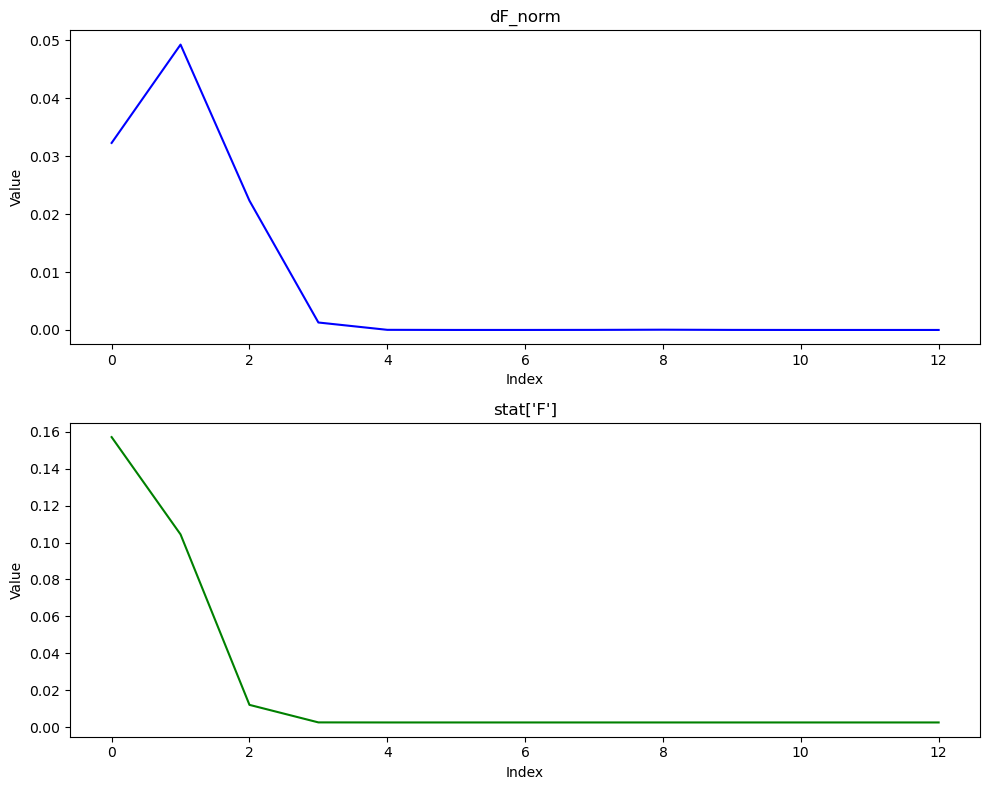

In [185]:
dF_norm = [np.linalg.norm(dF) for dF in stat['dF']]

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Use (1, 2) for side-by-side, (2, 1) for stacked

# Plot dF_norm on the first subplot
axs[0].plot(dF_norm, color='blue')
axs[0].set_title('dF_norm')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Plot stat['F'] on the second subplot
axs[1].plot(stat['F'], color='green')
axs[1].set_title('stat[\'F\']')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [186]:
def phi(x,t):
    return x[0]*np.exp(x[2]*t) + x[1]*np.exp(x[3]*t)

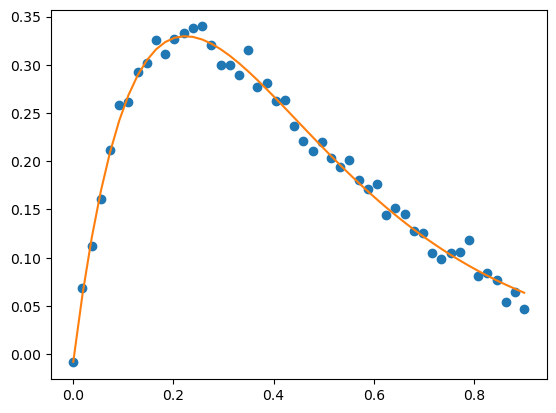

In [187]:
yopt = phi(xopt,t)

plt.plot(t, y, 'o')
plt.plot(t, yopt)
plt.show()

# 3. Data fitting

In [188]:
def linearLSQ(A, y):
    Q, R = np.linalg.qr(A)
    return np.linalg.solve(R, Q.T @ y)

In [189]:
t = np.array([-1.5, -0.5, 0.5, 1.5, 2.5])
y = np.array([0.80, 1.23, 1.15, 1.48, 2.17])

# Create the matrix A based on φ(x, t) = x1 * t + x2
# Each row of A is [ti, 1] where ti is from t array
A = np.vstack((t, np.ones_like(t))).T

# Find the least-squares solution x*
x_star = linearLSQ(A, y)

# Calculate the residual r(x*) and objective function f(2)(x*) = ∥r(x*)∥2
r = A @ x_star - y
f_x_star = np.linalg.norm(r, 2)

# Output the results
print("Least-squares solution x*:", x_star)
print("Objective function value f(2)(x*):", f_x_star)

Least-squares solution x*: [0.299  1.2165]
Objective function value f(2)(x*): 0.38847136316593534
